In [6]:
import requests, json, os, configparser
import matplotlib.pyplot as plt
import numpy as np

config = configparser.ConfigParser()
config.read(".secrets")

api_key = config["DEFAULT"]["API_KEY"]

cycles_query = """
{
    cycles {
        nodes {
            id
            name
        }
    }
}
"""

issues_query = """
{
    cycle(id: "CYCLE_ID") {
        id
        name
        issues(first: 200) {
            nodes {
                state {
                    name
                }
                estimate
            }
        }
    }
}
"""

statuses = [
    "Backlog",
    "Todo",
    "In Progress",
    "Code Complete",
    "Code Review & QA",
    "Ready for Release",
    "Internal Testing",
    "Phased Rollout",
    "Rollout Complete",
    "Task Complete",
    "Canceled",
]

s_len = len(statuses)

bar_colors = [
    '#1f77b4',
    '#ff7f0e',
    '#2ca02c',
    '#d62728',
    '#9467bd',
    '#8c564b',
    '#e377c2',
    '#7f7f7f',
    '#bcbd22',
    '#17becf',
    '#bada55',
]

def get_points(issue):
    return issue["estimate"] or 1 # Ok default estimate?

def get_issues(response_json):
    return response_json["data"]["cycle"]["issues"]["nodes"]

class Grouping:
    def __init__(self, name):
        self.name = name
        self.points = 0

def request_json(post_body):
    response = requests.request(
        "POST",
        "https://api.linear.app/graphql",
        headers={
          'Authorization': api_key,
          'Content-Type': 'application/json',
        },
        data=json.dumps({ "query": post_body }))
    return response.json()

def partition_issues(response_json):
    groupings = []
    for status in statuses:
        grouping = Grouping(status)
        for issue in get_issues(response_json):
            if issue["state"]["name"] == grouping.name:
                grouping.points += get_points(issue)
        groupings.append(grouping)
    return sorted(groupings, key=lambda g: -statuses.index(g.name))

In [7]:
# Send request to see all cycles (id, name)
response_json = request_json(cycles_query)

for cycle in response_json["data"]["cycles"]["nodes"]:
    print(cycle["name"], "->", cycle["id"])

None -> 408e6c86-031c-4ad3-a971-64532958216b
2024.9 -> 2f0d3dc1-f7ee-444d-b216-9c876807edec
2024.8 -> 876a5869-eb96-4263-b3d7-3198bb8c6ebd
2024.7 -> 78b58180-c5af-4d49-bf52-2c602745342e
2024.6 -> a8f21e06-ae07-4d0b-95c6-18ae64f67c69
2024.5 -> 55d8d04f-d8c3-419e-a21e-a906d02d7a10
2024.4 -> 2a93892c-db94-4864-9a82-4f3eb7271666
2024.3 -> d4500daa-79b4-4ebf-a2b5-9a9ff265f482
2024.2 -> 2ded66ae-4101-491a-9c31-bf5cde71488f
2024.1 -> c2b67e6a-0c49-40cc-aefe-186d9f6f01c3
2023.18 -> 330e63f5-1cbb-4c09-be0c-22932267f812
2023.17 -> f996c906-74fb-452f-a07f-78323ba45e22
2023.16 -> e1971691-ecc9-4570-bbb7-70b730cb82a0
2023.15 -> cee3228e-861d-4837-a27d-20c35e8c47ed
2023.14 -> 05c053a2-4bb6-4700-9b7d-86ef3fb4e960
2023.13 -> 70989c0a-a00c-4365-9010-1ed4f1695121
2023.12 -> a547d0a4-4c32-4133-9774-a8ac72006d59
2023.11 -> ad0c1506-b5c8-4986-a341-0b56bb58e2ac
2023.10 -> 13a04eba-675c-4dcf-8911-b62c655187c7
2023.9 -> 22934853-0909-49e2-8169-ad3c42b2a264


In [5]:
# This is where you enter the ID of the current cycle
current_cycle = "78b58180-c5af-4d49-bf52-2c602745342e"

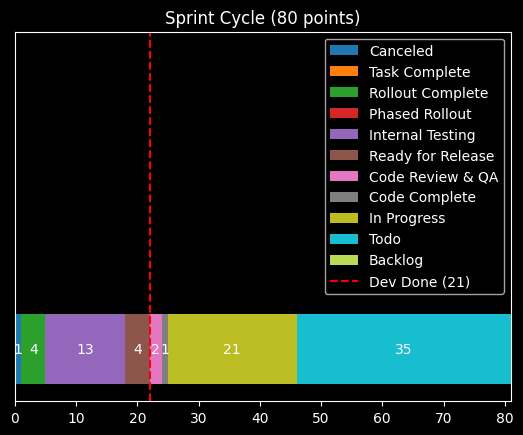

In [9]:
# Get issues from current_cycle
response_json = request_json(issues_query.replace("CYCLE_ID", current_cycle))

# Outfit data to pass to renderer
chart_data = partition_issues(response_json)

def render_chart(groupings):
    fig, ax = plt.subplots()
    values = [g.points for g in groupings]
    category_labels = [g.name for g in groupings]
    sprint_points = sum([g.points for g in groupings if g.name != "Canceled"])
    bar_labels = [p or "" for p in values]
    bar_width = 0.25
    bar_y_pos = 0

    y_positions = [bar_y_pos] * s_len
    heights = [bar_width] * s_len

    # cumulative sums
    x_positions = [0]
    for p in values[:-1]:
        x_positions += [x_positions[-1] + p]

    # Hack because I don't know how increase margin-top of the bars.
    # By default it wants to fill the entire container.
    x_positions += [0]; y_positions += [1]; values += [0]; heights += [0.15]; category_labels += [""]; bar_labels += [""]
    
    container = ax.barh(
        left=x_positions,
        y=y_positions,
        width=values,
        height=heights,
        label=category_labels,
        color=bar_colors)

    # Add the goal line for "dev work done"
    threshold_i = category_labels.index("Code Review & QA")
    threshold_total = sum([g.points for g in groupings[:threshold_i] if g.name != "Canceled"])
    threshold = x_positions[threshold_i]
    ax.axvline(x=threshold, color="red", linestyle="--", label=f"Dev Done ({threshold_total})")
    
    ax.set_yticks([])
    ax.bar_label(container, labels=bar_labels, label_type="center")
    ax.set_title(f"Sprint Cycle ({sprint_points} points)")
    ax.legend(loc="upper right")
    
    plt.style.use('dark_background')
    plt.show()

render_chart(chart_data)